In [1]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


## IMPORTING YOLOV9

In [2]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
%pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 325 (delta 159), reused 156 (delta 156), pack-reused 107 (from 1)
Receiving objects: 100% (325/325), 2.23 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/kaggle/working/yolov9
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q roboflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
%cd {HOME}/yolov9

/kaggle/working/yolov9


In [5]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import transforms
from roboflow import Roboflow

## IMPORTING DATASET

In [6]:
rf = Roboflow(api_key="tota6j5Pihs2uR5PF1l8")
project = rf.workspace("first-yqrjh").project("last-jhd0w")
version = project.version(10)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to last-10 in yolov9:: 100%|██████████| 15366/15366 [00:01<00:00, 8844.17it/s]


In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

## TRAINING

In [8]:
!python train.py \
--batch 16 --epochs 25 --img 512 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/kaggle/working/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/kaggle/working/yolov9/last-10/data.yaml, hyp=hyp.scratch-high.yaml, epochs=25, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 1e33dbb Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269

## LISTING TRAINING RESULTS

In [11]:
!ls {HOME}/yolov9/runs/train/exp


F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1724459348.bb97ce748e64.107.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


## Display training results

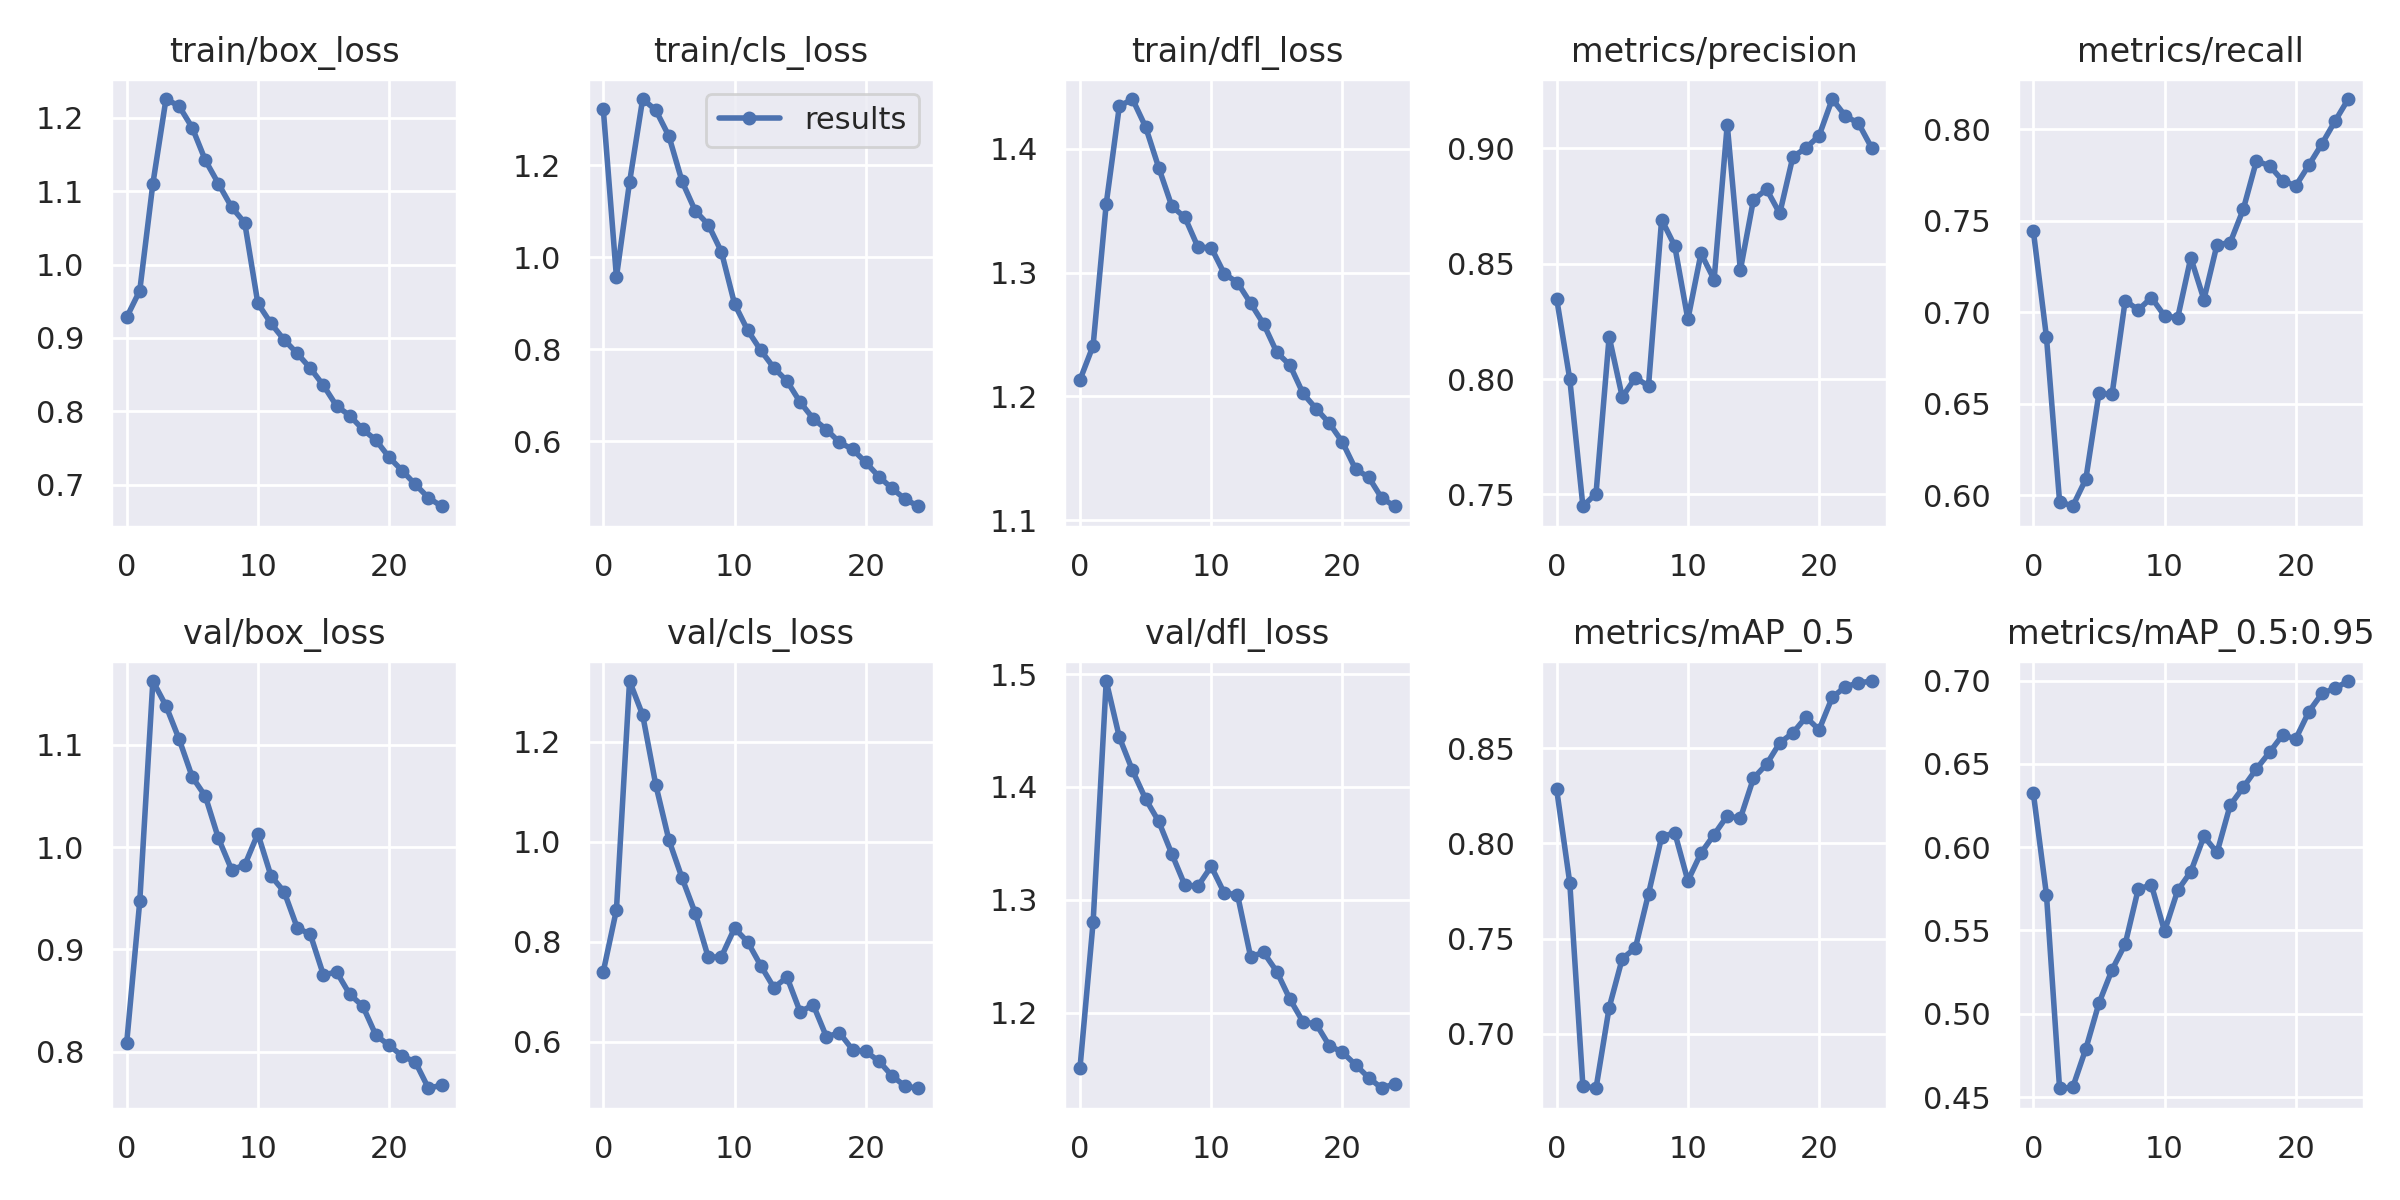

In [12]:
from IPython.display import Image
Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

## Display confusion matrix

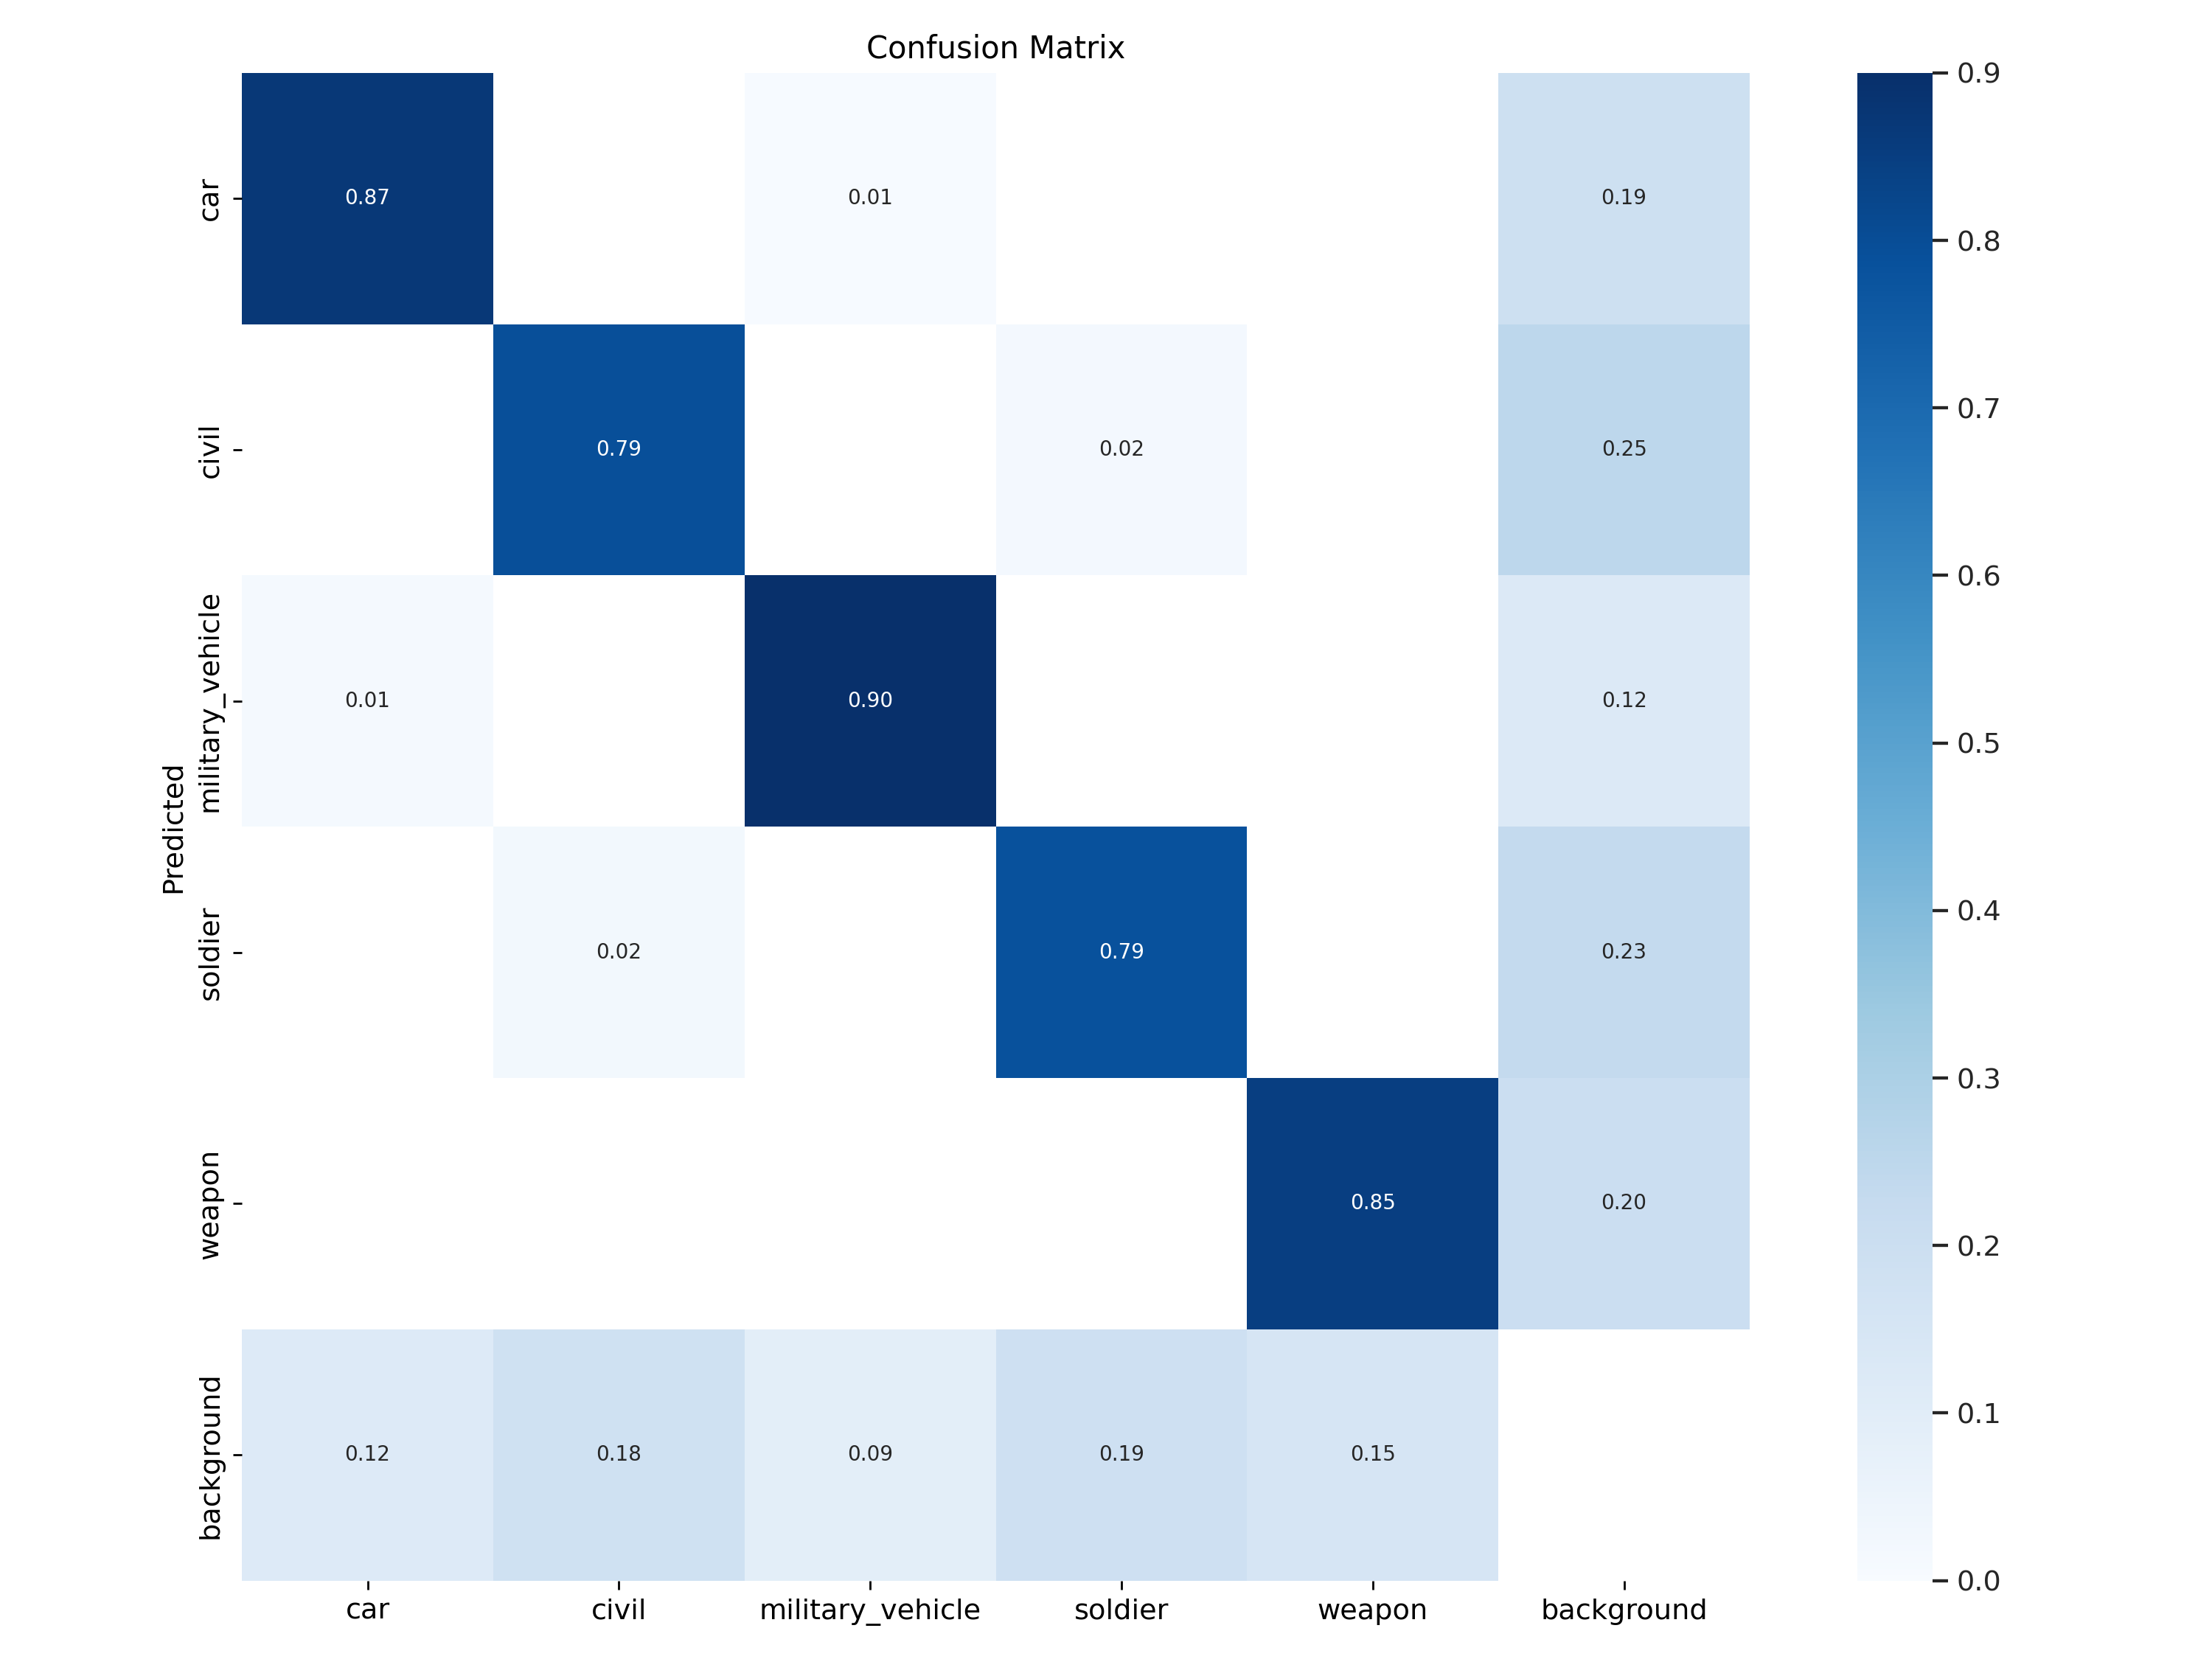

In [14]:
Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)


## Display validation batch predictions

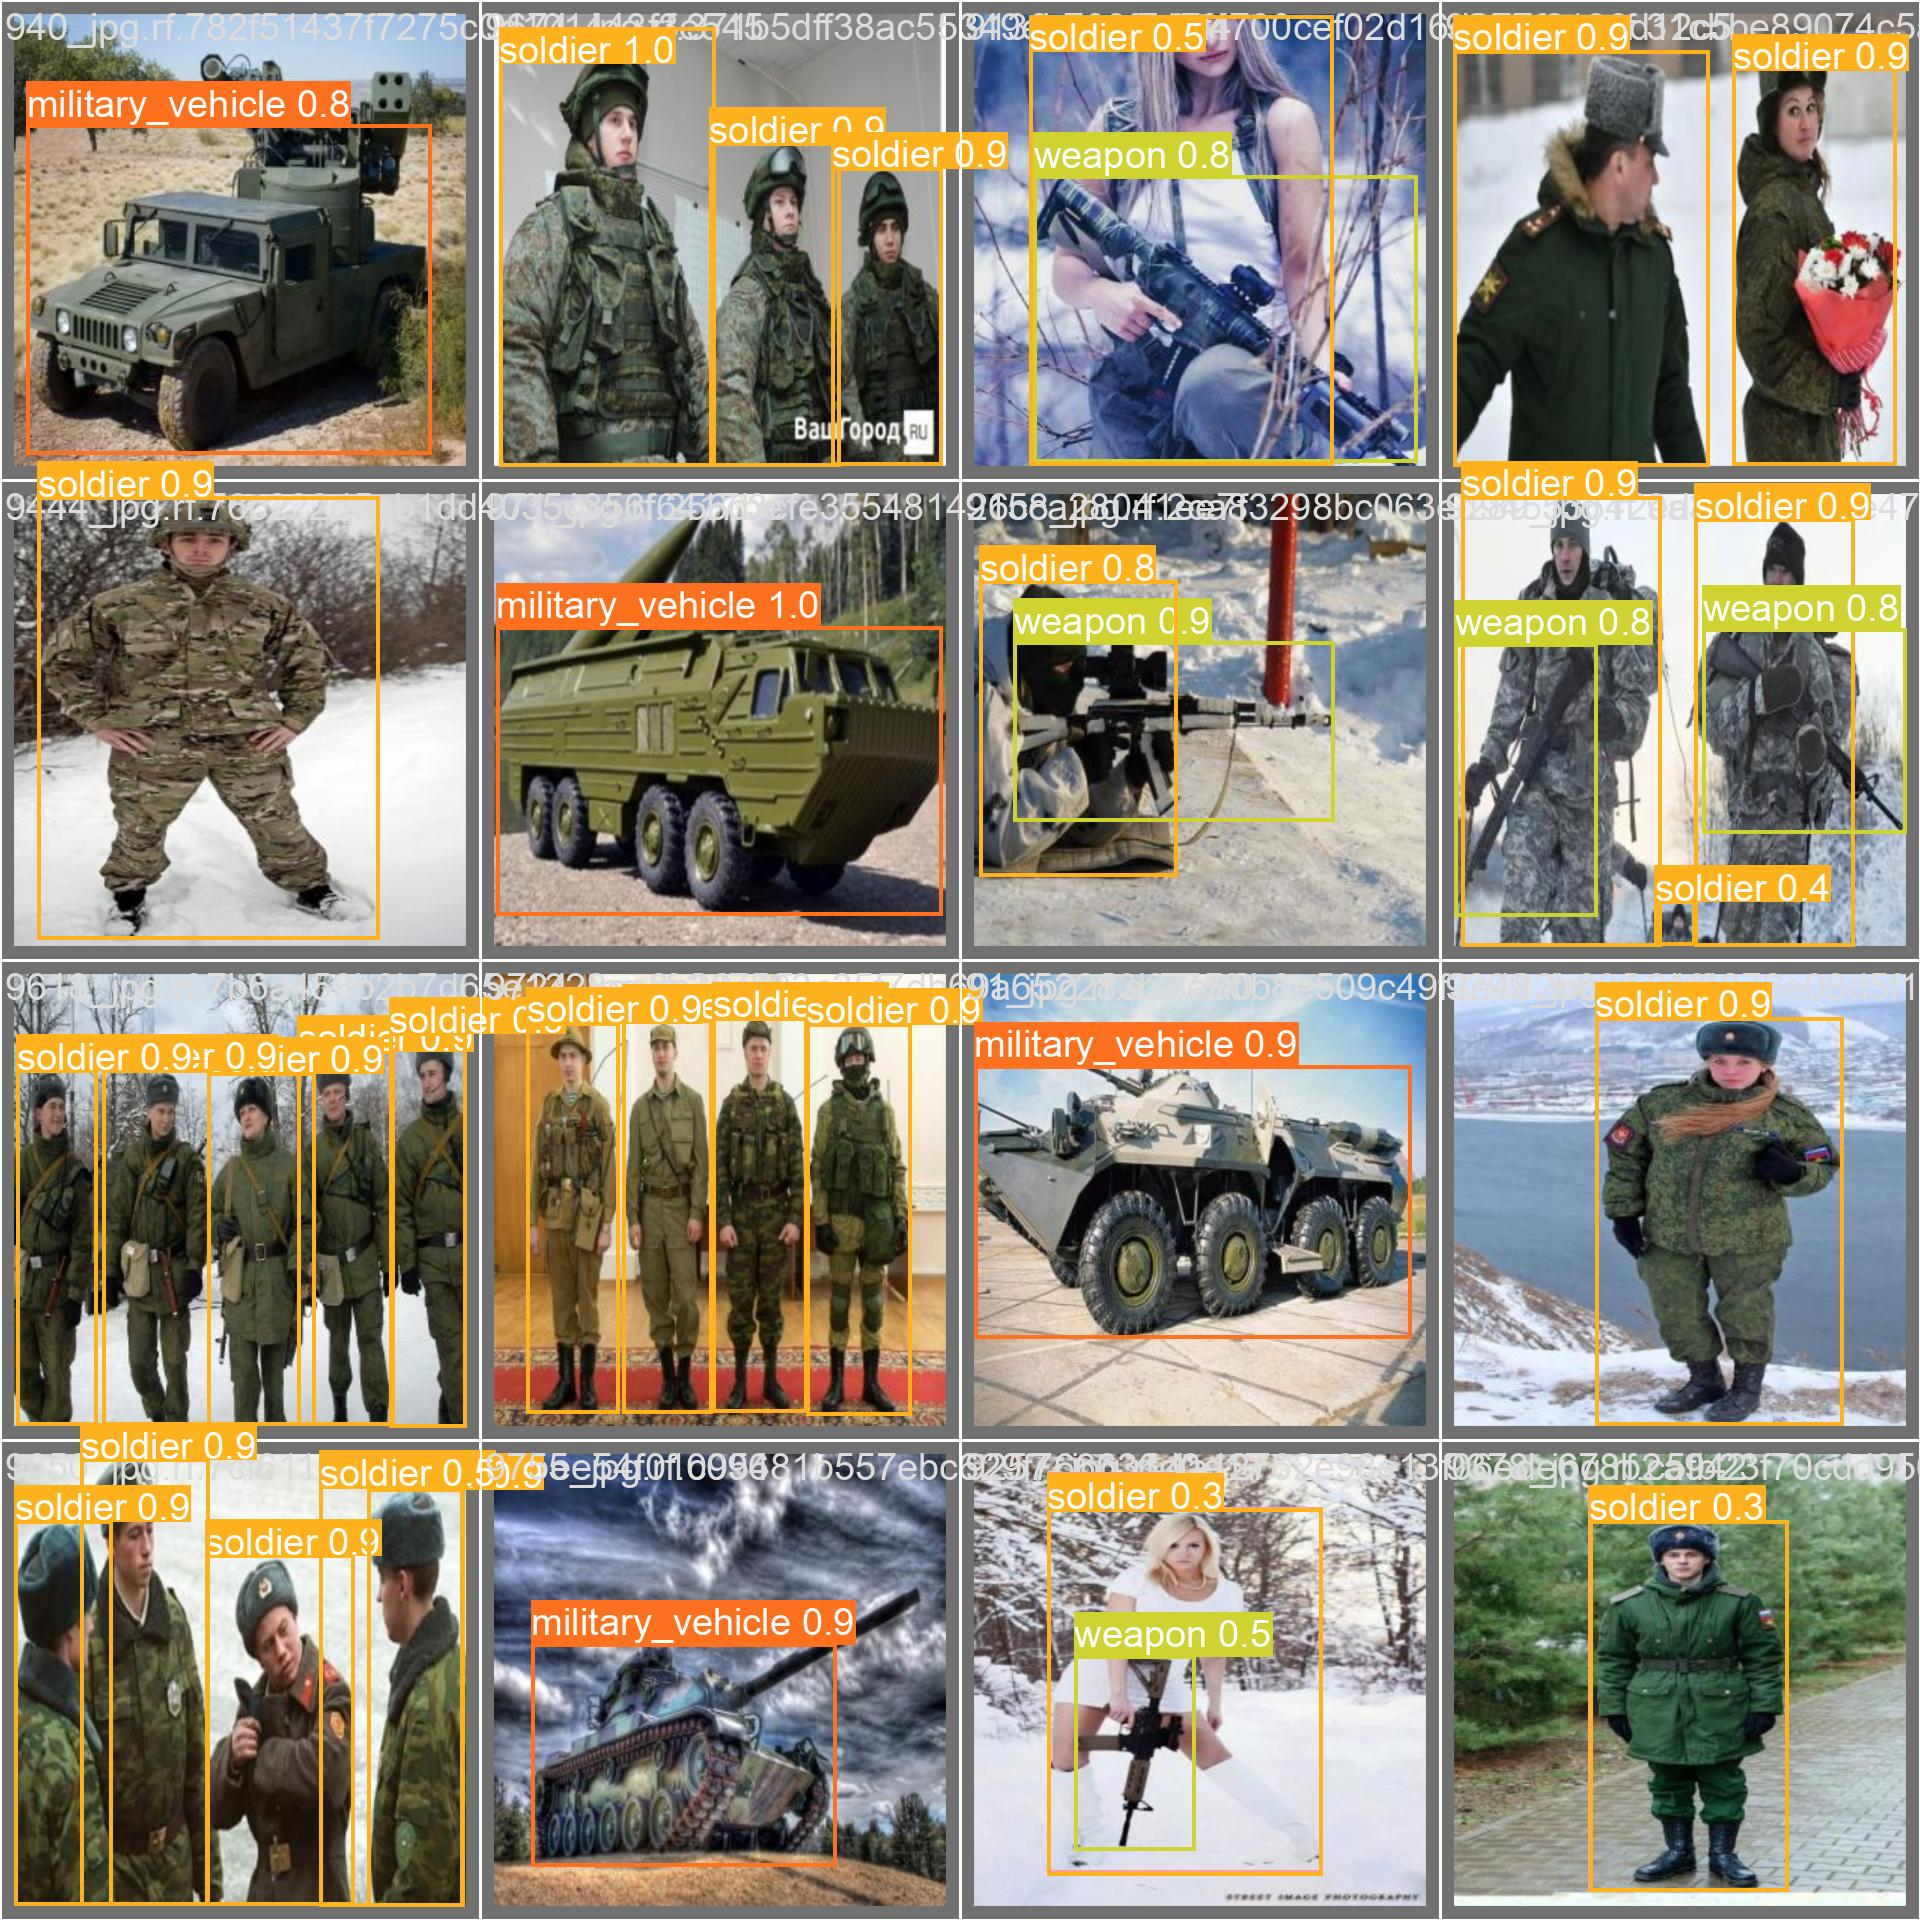

In [15]:

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)


## Define functions for model saving, loading, and object detection

In [23]:
%cd /kaggle/working

/kaggle/working


In [27]:
import torch
import os
import sys

# Add the current directory to the Python path
sys.path.append('/kaggle/working')

# Import necessary modules from YOLOv9
from yolov9.models.yolo import Model
from yolov9.utils.torch_utils import select_device

# Set the output directory for saving the model
OUTPUT_DIR = '/kaggle/working/'

def save_model(model, output_dir=OUTPUT_DIR):
    os.makedirs(output_dir, exist_ok=True)
    model_filename = os.path.join(output_dir, 'yolov9_model.pt')
    torch.save(model, model_filename)
    print(f"Model saved to {model_filename}")
    return model_filename

# Load the trained weights
ckpt = torch.load('yolov9/runs/train/exp/weights/best.pt', map_location='cpu')

# Extract the model from the checkpoint
if 'ema' in ckpt:
    model = ckpt['ema']
elif 'model' in ckpt:
    model = ckpt['model']
else:
    model = ckpt

print("Model loaded successfully.")

# Save the model
saved_model_path = save_model(model)
print(f"Model saved to: {saved_model_path}")

def load_model(model_path, device=''):
    device = select_device(device)
    model = torch.load(model_path, map_location=device)
    if isinstance(model, dict):
        model = model['model'] if 'model' in model else model['ema']
    model = model.to(device)
    model.eval()
    return model

# Load the saved model
loaded_model = load_model(saved_model_path)
print("Model loaded successfully for inference.")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Model loaded successfully.
Model saved to /kaggle/working/yolov9_model.pt
Model saved to: /kaggle/working/yolov9_model.pt


YOLOv5 🚀 1e33dbb Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Model loaded successfully for inference.


## SAVING, LOADIND AND TESTING THE MODEL


In [40]:
import torch
import numpy as np
from PIL import Image as PILImage
import torchvision.transforms as transforms
import cv2

def detect_objects(image_path, model):
    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    try:
        # Load and preprocess the image
        img = PILImage.open(image_path).convert('RGB')
        original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        img = transforms.ToTensor()(img)
        
        # Resize the image to match the model's expected input size (512x512 as per your training script)
        img = transforms.Resize((512, 512))(img)
        
        img = img.unsqueeze(0)  # Add batch dimension
        img = img.to(device).to(dtype)  # Move to the same device and dtype as the model

        # Perform inference
        with torch.no_grad():
            pred = model(img)

        # Print model output structure
        print("Model output structure:")
        if isinstance(pred, (list, tuple)):
            for i, p in enumerate(pred):
                print(f"Element {i} type: {type(p)}, shape: {p.shape if hasattr(p, 'shape') else 'N/A'}")
        elif isinstance(pred, torch.Tensor):
            print(f"Type: Tensor, Shape: {pred.shape}")
        else:
            print(f"Type: {type(pred)}")

        # Process predictions
        detections = []
        if isinstance(pred, (list, tuple)) and len(pred) > 0:
            pred_tensor = pred[0]  # Take the first element, which is a tensor
            pred_tensor = pred_tensor.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy
            
            num_classes = pred_tensor.shape[1] - 5  # Assuming last 5 columns are for box coordinates and objectness
            for i in range(pred_tensor.shape[0]):
                row = pred_tensor[i]
                objectness = row[4]
                if objectness > 0.25:  # Objectness threshold
                    class_scores = row[5:]
                    class_id = np.argmax(class_scores)
                    class_score = class_scores[class_id]
                    if class_score > 0.25:  # Class confidence threshold
                        x, y, w, h = row[:4]
                        x1, y1 = x - w/2, y - h/2
                        x2, y2 = x + w/2, y + h/2
                        detections.append((x1, y1, x2, y2, class_score, class_id))
                        print(f"Detected object: class {class_id}, confidence {class_score:.2f}, bounding box {(x1, y1, x2, y2)}")

        # Visualize results
        if detections:
            for x1, y1, x2, y2, conf, cls in detections:
                label = f'Class {cls} {conf:.2f}'
                cv2.rectangle(original_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(original_img, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            
            cv2.imwrite('result.jpg', original_img)
            print("Detection result saved as 'result.jpg'")

        return detections
    except Exception as e:
        print(f"Error in object detection: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Load the model
model_path = '/kaggle/working/yolov9_model.pt'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = torch.load(model_path, map_location=device)
loaded_model.eval()
loaded_model.to(device)

if loaded_model is not None:
    # Perform object detection on a sample image
    sample_image_path = "/kaggle/working/yolov9/last-10/valid/images/1900_jpg.rf.5e39eda3f6e290e3a77d5651fb000024.jpg"
    print(f"Performing detection on image: {sample_image_path}")
    results = detect_objects(sample_image_path, loaded_model)

    if results is not None:
        print("Detection completed. Check the output above for results and 'result.jpg' for visualization.")
    else:
        print("Detection failed.")
else:
    print("Model loading failed. Cannot perform detection.")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Performing detection on image: /kaggle/working/yolov9/last-10/valid/images/1900_jpg.rf.5e39eda3f6e290e3a77d5651fb000024.jpg
Model output structure:
Element 0 type: <class 'torch.Tensor'>, shape: torch.Size([1, 9, 5376])
Element 1 type: <class 'list'>, shape: N/A
Detected object: class 1338, confidence 508.50, bounding box (5.0, 3.0390625, 22.34375, 27.8828125)
Detected object: class 4059, confidence 506.50, bounding box (17.25, 18.8359375, 38.15625, 36.5078125)
Detected object: class 5361, confidence 478.00, bounding box (14.40625, 11.296875, 42.59375, 50.484375)
Detected object: class 4578, confidence 401.00, bounding box (36.1875, 37.453125, 77.5, 72.609375)
Detection result saved as 'result.jpg'
Detection completed. Check the output above for results and 'result.jpg' for visualization.
